In [1]:
#Importações
import pandas as pd
import numpy as np
import pycaret.classification as pc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
import os
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss

from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report


Configuração MLFOW

In [2]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlflow.db")

experiment_name = 'ProjetoKobe '
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

Analise exploratoria

In [3]:
def shapeArtefato(df):
    # Obtendo o número de linhas e colunas do DataFrame
    num_linhas = df.shape[0]
    num_colunas = df.shape[1]

    # Registrando as métricas no MLflow
    mlflow.log_metrics({"Número de Linhas": num_linhas, "Número de Colunas": num_colunas})


In [4]:
def matrixCorrelacao(df, titulo):
    df_numeric = df.select_dtypes(include=['number'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Matriz de Correlação - {titulo}", fontsize=16)
    plt.tight_layout()
    temp_file =  f"{titulo}.png"
    plt.savefig(temp_file)
    plt.close()
    mlflow.log_artifact(temp_file, artifact_path=f"{titulo}.png")

In [5]:
def boxplot_faixa_dinamica(df, titulo):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, palette="Set3", linewidth=2.5)
    plt.title(f"Gráfico de Box Plot - Faixa Dinâmica das Variáveis -  {titulo}")
    plt.xlabel("Variáveis")
    plt.ylabel("Valores")
    plt.xticks(rotation=45)
    temp_file =  f"{titulo}.png"
    plt.savefig(temp_file)
    mlflow.log_artifact(temp_file, artifact_path=f"{titulo}.png")

In [6]:
def histogramaVariaveis(df,titulo):
    plt.figure(figsize=(12, 8))
    df.hist(figsize=(12, 8))
    plt.suptitle("Histograma das Variáveis", fontsize=16)
    plt.tight_layout()
    histogram_path = f"{titulo}.png"
    plt.savefig(histogram_path)
    plt.close()
    mlflow.log_artifact(histogram_path, artifact_path=f"{titulo}.png")

In [7]:
csv_path = ''

def dadosNulosArtefato(df, titulo):
    # Contagem de valores nulos por coluna
    valores_nulos_por_coluna = df.isnull().sum()
    # Tipos das colunas
    tipos_colunas = df.dtypes
    # Criando um DataFrame para exibir os resultados
    tabela_valores_nulos = pd.DataFrame({'Coluna': valores_nulos_por_coluna.index,
                                         'Tipo': tipos_colunas,
                                         'Valores Nulos': valores_nulos_por_coluna})
    # Salvando o DataFrame como um arquivo CSV
    global csv_path
    csv_path =  f"{titulo}.png"
    tabela_valores_nulos.to_csv(csv_path, index=False)
    mlflow.log_artifact(csv_path, artifact_path=  f"{titulo}.png")
    

<Figure size 1200x800 with 0 Axes>

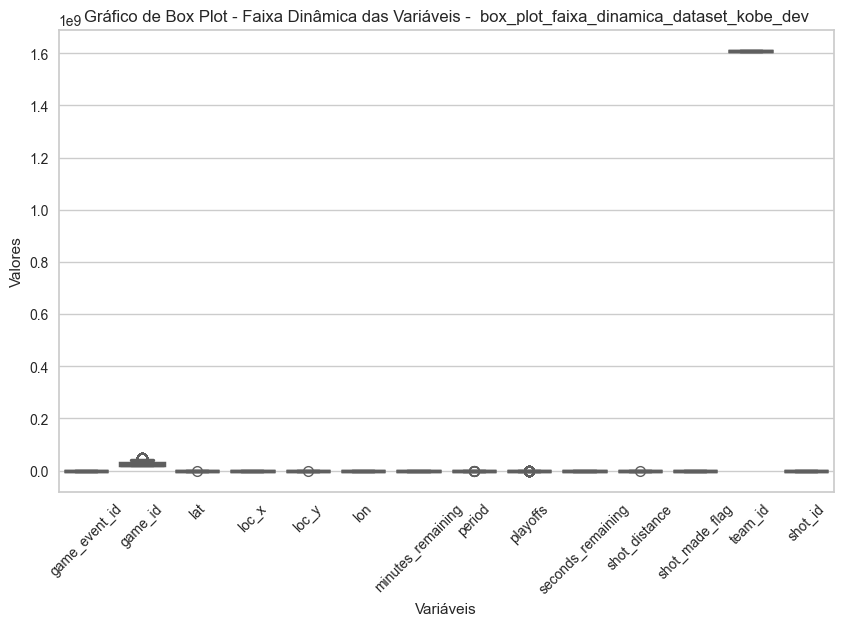

In [8]:
#MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name='AnaliseExploratoria'):
    df_dev = pd.read_parquet("../data/raw/dataset_kobe_dev.parquet")
    dadosNulosArtefato(df_dev,'dados_nullos_dataset_kobe_dev')
    histogramaVariaveis(df_dev,'histograma_variaveis_dataset_kobe_dev')
    boxplot_faixa_dinamica(df_dev, 'box_plot_faixa_dinamica_dataset_kobe_dev')
    matrixCorrelacao(df_dev,"matriz_correlacao_dataset_kobe_dev")
    shapeArtefato(df_dev)
    
    

Preparação dos dados

In [9]:

#MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name='PreparacaoDados'):
   
    percentual_treino = 0.8
    
  
    df_dev = pd.read_parquet("../data/raw/dataset_kobe_dev.parquet")
    
    # Colunas selecionadas
    colunas_selecionadas = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']

    # Carregar o DataFrame a partir do arquivo parquet
    df_dev = pd.read_parquet("../data/raw/dataset_kobe_dev.parquet")

    # Remover todas as colunas que não estão na lista 'colunas_selecionadas'
    colunas_para_remover = [coluna for coluna in df_dev.columns if coluna not in colunas_selecionadas]
    df_dev.drop(columns=colunas_para_remover, inplace=True)
    df_dev = df_dev.dropna()

    df_dev.to_parquet('../data/processed/data_filtered.parquet', index=False)
    df_dev['shot_made_flag'] = df_dev['shot_made_flag'].astype(int)
    xtrain, xtest, ytrain, ytest =  train_test_split(df_dev[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']],
                                                     df_dev['shot_made_flag'],
                                                     test_size= percentual_treino,
                                                     stratify=df_dev['shot_made_flag']
                                                   )
   
    xtrain['shot_made_flag'] = ytrain
    ytrain['shot_made_flag'] = ytest
   
    xtrain.to_parquet("../data/processed/base_train.parque")
    xtest.to_parquet("../data/processed/base_test.parque")   
   
     # Registre os parâmetros e métricas no MLflow
    mlflow.log_param('percentual_test', 1 - percentual_treino)
    mlflow.log_param('colunas_selecionadas', colunas_selecionadas)
    mlflow.log_metric('qtd_linhas_treino', xtrain.shape[0])
    mlflow.log_metric('qtd_linhas_test', xtest.shape[0])

In [10]:
mlflow.end_run()

Treinamento

In [11]:
# Função para plotar a matriz de confusão
def plot_confusion_matrix(cm, title, filename):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.savefig(filename)
    mlflow.log_artifact(filename)
    plt.show()

,Description,Value
0,Session id,5733
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(4057, 7)"
6,Transformed test set shape,"(16228, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5817,0.4902,0.5038,0.5704,0.5343,0.1574,0.1588,0.2600
dt,Decision Tree Classifier,0.5203,0.4986,0.5308,0.4981,0.5134,0.0415,0.0416,0.0160


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5767,0.5966,0.4929,0.5649,0.5264,0.1470,0.1481


Log Loss: 3.179433198267293
Recall (Regressão Logística): 0.49289956106377486
Precision (Regressão Logística): 0.564876461014943
F1-score (Regressão Logística): 0.5264391589107205


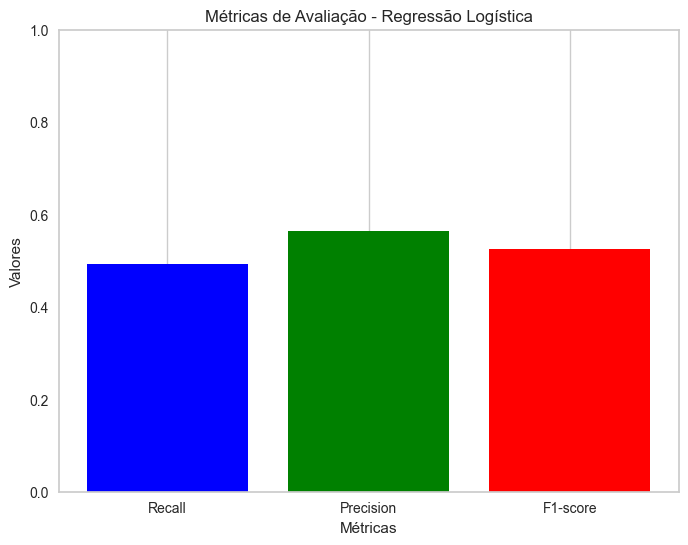

<Figure size 800x550 with 0 Axes>

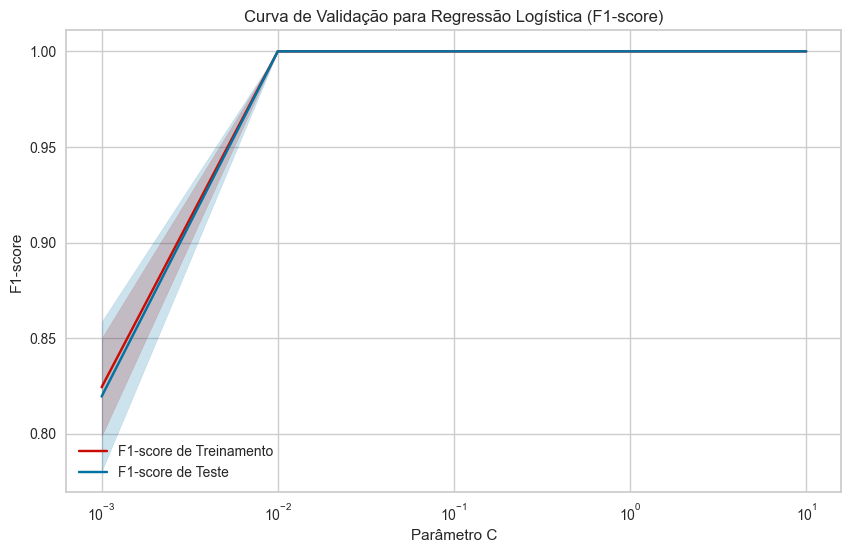

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5275,0.5153,0.5482,0.5047,0.5255,0.0567,0.0569


Log Loss (Árvore de Decisão): 17.029004839435615
Recall (Árvore de Decisão): 0.5481538858765814
Precision (Árvore de Decisão): 0.5046951147034352
F1-score (Árvore de Decisão): 0.5255275697753574


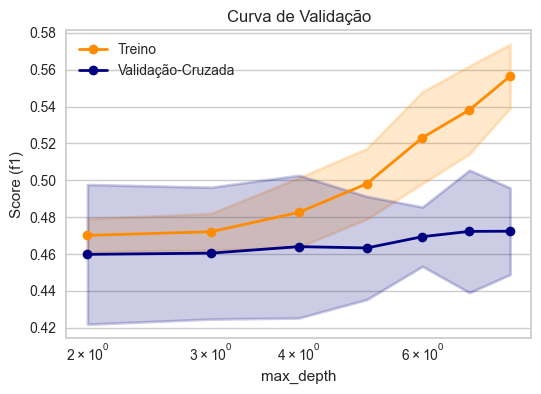

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5862,0.4380,0.6082,0.5619,0.5842,0.1737,0.1742
1,0.6084,0.5000,0.5412,0.6000,0.5691,0.2119,0.2129
2,0.5936,0.5000,0.5773,0.5744,0.5758,0.1858,0.1858
3,0.5936,0.4830,0.5361,0.5810,0.5576,0.1829,0.1834
4,0.5813,0.5000,0.5876,0.5588,0.5729,0.1627,0.1629
5,0.6010,0.5000,0.5567,0.5870,0.5714,0.1986,0.1989
6,0.5665,0.4826,0.5206,0.5489,0.5344,0.1294,0.1296
7,0.5728,0.5000,0.5596,0.5510,0.5553,0.1444,0.1444
8,0.5012,0.5000,0.4611,0.4759,0.4684,-0.0011,-0.0011


Fitting 10 folds for each of 4 candidates, totalling 40 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5725,0.5966,0.5423,0.5533,0.5478,0.1426,0.1426


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'kobe' already exists. Creating a new version of this model...
Created version '61' of model 'kobe'.


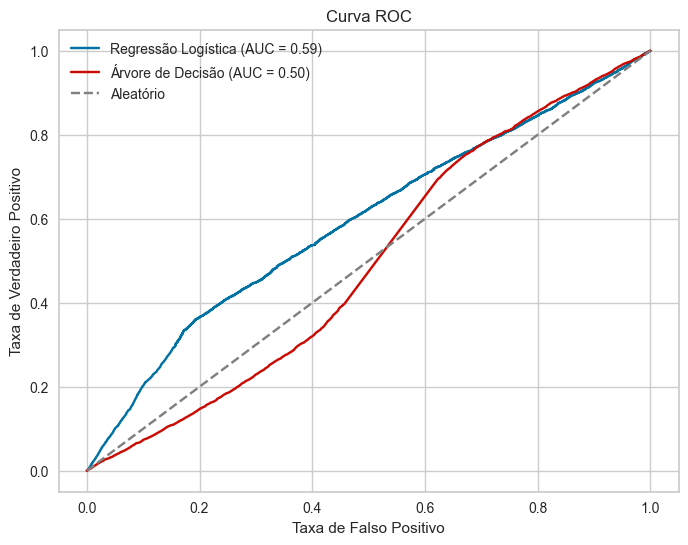

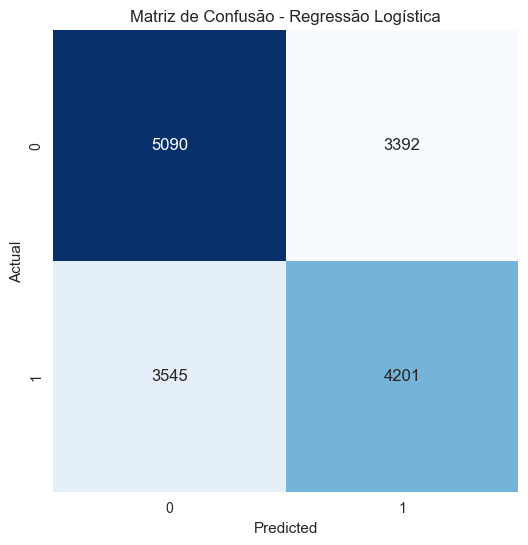

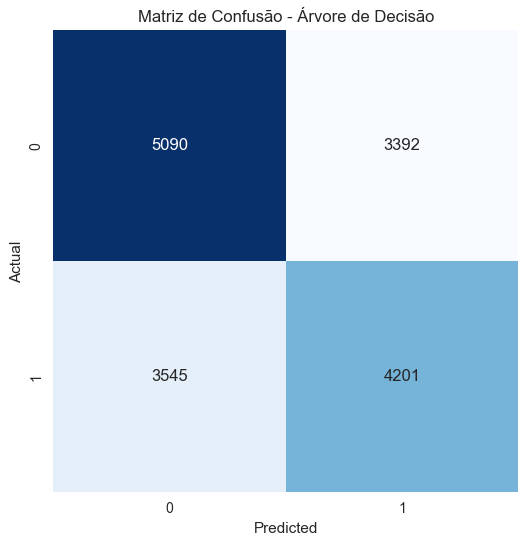

Distribuição da variável alvo no conjunto de treinamento:
shot_made_flag
0    0.522554
1    0.477446
Name: count, dtype: float64

Distribuição da variável alvo no conjunto de teste:
shot_made_flag
0    0.522677
1    0.477323
Name: count, dtype: float64
Melhor modelo: 0


In [12]:
registered_model_name = 'kobe'
nexamples = 5
model_version = -1
# MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name='Treinamento'):
    colunas_selecionadas = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
    xtrain, xtest, ytrain, ytest =  train_test_split(df_dev, df_dev['shot_made_flag'], test_size= percentual_treino,stratify=df_dev['shot_made_flag'])
    exp = pc.setup( data = xtrain, target = 'shot_made_flag',test_data = xtest, normalize=True,log_experiment=False)
    lista_modelos = exp.compare_models(['lr','dt'], n_select=2, sort='f1')

    # Obter o modelo de regressão logística da lista de modelos
    # Acionado este filtro para verificar o tipo do modelo antes de criar os graficos.
    logistic_model = [model for model in lista_modelos if str(model).startswith("LogisticRegression")][0]

    # Verificar se o modelo é de regressão logística
    if isinstance(logistic_model, LogisticRegression):

        yhat_test = exp.predict_model(logistic_model)
        # Selecionar apenas as características do conjunto de teste que o modelo de regressão logística viu durante o treinamento
        xtest_features = xtest.drop(columns=['shot_made_flag'])

        # Obter as probabilidades previstas usando o método predict_proba() do modelo de regressão logística
        y_pred_proba = logistic_model.predict_proba(xtest_features)[:, 1]
        y_pred_proba_lr =y_pred_proba
        # Calcular o log loss
        logloss = log_loss(ytest, y_pred_proba)

        print("Log Loss:", logloss)
        # Calculando as métricas
        recall_lr = recall_score(ytest, yhat_test['prediction_label'])
        precision_lr = precision_score(ytest, yhat_test['prediction_label'])
        f1_lr = f1_score(ytest, yhat_test['prediction_label'])

        # Exibindo as métricas
        print("Recall (Regressão Logística):", recall_lr)
        print("Precision (Regressão Logística):", precision_lr)
        print("F1-score (Regressão Logística):", f1_lr)

        # Criando o gráfico de barras
        metrics = ['Recall', 'Precision', 'F1-score']
        values = [recall_lr, precision_lr, f1_lr]

        plt.figure(figsize=(8, 6))
        plt.bar(metrics, values, color=['blue', 'green', 'red'])
        plt.xlabel('Métricas')
        plt.ylabel('Valores')
        plt.title('Métricas de Avaliação - Regressão Logística')
        plt.ylim(0, 1)  # Definindo o intervalo do eixo y de 0 a 1
        plt.grid(axis='y')  # Adicionando grade no eixo y
        plt.show()

        # Salvar o gráfico no MLflow
        plt.savefig('metricas_regressao_logistica.png')
        mlflow.log_artifact('metricas_regressao_logistica.png')


        model = logistic_model
        # Definir os valores de parâmetros que queremos testar
        param_range = [0.001, 0.01, 0.1, 1, 10]
        # Calcular as curvas de validação para diferentes valores de parâmetros
        scorer = make_scorer(f1_score)
        train_scores, test_scores = validation_curve(
          model, 
          xtrain, 
          ytrain, 
          param_name="C", 
          param_range=param_range, 
          scoring=scorer, 
          n_jobs=-1
      )

        # Calcular a média e o desvio padrão das pontuações de treinamento e teste
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        # Plotar as curvas de validação
        plt.figure(figsize=(10, 6))
        plt.title("Curva de Validação para Regressão Logística (F1-score)")
        plt.xlabel("Parâmetro C")
        plt.ylabel("F1-score")
        plt.semilogx(param_range, train_mean, label="F1-score de Treinamento", color="r")
        plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
        plt.semilogx(param_range, test_mean, label="F1-score de Teste", color="b")
        plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="b")
        plt.legend(loc="best")
        # Salvar a figura
        plt.savefig('curva_validacao_regressao_logistica.png')
        mlflow.log_artifact("curva_validacao_regressao_logistica.png")
        plt.show()

      #  f1_lr = f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label'])
        mlflow.log_metrics({
            'lr_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
            'lr_f1':f1_lr ,
            'lr_recall':recall_lr,
            'lr_precision':precision_lr
       })

    # Obter o modelo de árvore de decisão da lista de modelos
    decision_tree_model = [model for model in lista_modelos if isinstance(model, DecisionTreeClassifier)][0]

    # Verificar se o modelo é um classificador de árvore de decisão
    if isinstance(decision_tree_model, DecisionTreeClassifier):

        yhat_test = exp.predict_model(decision_tree_model)
         # Calcular o log loss
        logloss_dt = log_loss(ytest, yhat_test['prediction_label'])
        print("Log Loss (Árvore de Decisão):", logloss_dt)

        # Calcular e exibir as métricas
        recall_dt = recall_score(ytest, yhat_test['prediction_label'])
        precision_dt = precision_score(ytest, yhat_test['prediction_label'])
        f1_dt = f1_score(ytest, yhat_test['prediction_label'])
        print("Recall (Árvore de Decisão):", recall_dt)
        print("Precision (Árvore de Decisão):", precision_dt)
        print("F1-score (Árvore de Decisão):", f1_dt)
        mlflow.log_metrics({
            'dt_log_loss': logloss_dt,
            'dt_recall': recall_dt,
            'dt_precision': precision_dt,
            'dt_f1': f1_dt,
        })

        plt.figure(figsize=(6, 4))
        param_name = "max_depth"
        param_range = [2, 3, 4, 5, 6, 7, 8]
        scoring = "f1"
        train_scores, test_scores = validation_curve(decision_tree_model,
                                                      X=xtrain.drop('shot_made_flag', axis=1),
                                                      y=ytrain,
                                                      param_name=param_name,
                                                      param_range=param_range,
                                                      scoring=scoring,
                                                      cv=10,
                                                      n_jobs=-1)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.title("Curva de Validação")
        plt.xlabel(param_name)
        plt.ylabel("Score (" + scoring + ")")

        plt.semilogx(param_range, train_scores_mean, '-o', label="Treino", color="darkorange", lw=2)
        plt.semilogx(param_range, test_scores_mean, '-o', label="Validação-Cruzada", color="navy", lw=2)

        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=2)
        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=2)

        plt.legend(loc='best')
        plt.grid(True)

        plt.savefig("curva_validacao_arvore_decisao.png")
        mlflow.log_artifact("curva_validacao_arvore_decisao.png")
        plt.show()

        f1_dt = f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label'])
        mlflow.log_metrics({
          'dt_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
          'dt_f1': f1_dt ,
        })

    # Selecionando o melhor modelos com base no F1
    best_model = 0 if f1_lr > f1_dt else 1
    if best_model == 0:
        modelo_final = logistic_model
    else:
        modelo_final = decision_tree_model

    # FINALIZACAO MELHOR MODELO
    tune_model = exp.tune_model(modelo_final,
                                optimize = 'f1',
                                search_library = 'scikit-learn',
                                search_algorithm = 'random',
                                n_iter = 4) 

    yhat_test = exp.predict_model(tune_model, raw_score=True)  

    mlflow.log_metrics({
     'final_model_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
     'final_model_f1': f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
    })

    yhat_test.to_parquet('../data/processed/prediction_test.parquet')
    mlflow.log_artifact('../data/processed/prediction_test.parquet')

    final_model = exp.finalize_model(tune_model)
    # EXPORTACAO PARA LOG E REGISTRO DO MODELO
    exp.save_model(final_model, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = exp.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(xtrain.drop('shot_made_flag', axis=1).columns)

    inf_signature = infer_signature(xtrain[colunas_selecionadas], model_pipe.predict_proba(xtrain.drop('shot_made_flag', axis=1))) 

    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn='predict_proba'
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name    = registered_model_name, 
        alias   = "staging", 
        version = model_version
    ) 
   
 
    # Calcular as curvas ROC
    fpr_lr, tpr_lr, _ = roc_curve(ytest, y_pred_proba_lr)
    y_pred_proba_dt = yhat_test.iloc[:, 1]
    fpr_dt, tpr_dt, _ = roc_curve(ytest, y_pred_proba_dt)

    # Calcular as áreas sob a curva ROC (AUC)
    auc_lr = roc_auc_score(ytest, y_pred_proba_lr)
    auc_dt = roc_auc_score(ytest, y_pred_proba_dt)

    # Plotar as curvas ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {auc_lr:.2f})', color='b')
    plt.plot(fpr_dt, tpr_dt, label=f'Árvore de Decisão (AUC = {auc_dt:.2f})', color='r')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório')
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid(True)
    # Salvar a figura
    roc_curve_file = 'curva_roc.png'
    plt.savefig(roc_curve_file)
    mlflow.log_artifact(roc_curve_file)
    plt.show()
  
    # Matriz de confusão para Regressão Logística
    cm_lr = confusion_matrix(ytest, yhat_test['prediction_label'])
    plot_confusion_matrix(cm_lr, 'Matriz de Confusão - Regressão Logística', 'confusion_matrix_lr.png')
    # Matriz de confusão para Árvore de Decisão
    cm_dt = confusion_matrix(ytest, yhat_test['prediction_label'])
    plot_confusion_matrix(cm_dt, 'Matriz de Confusão - Árvore de Decisão', 'confusion_matrix_dt.png')
    mlflow.log_artifact('confusion_matrix_lr.png')
    mlflow.log_artifact('confusion_matrix_dt.png')
    # Contagem das ocorrências de cada classe da variável alvo no conjunto de treinamento
    train_counts = ytrain.value_counts()

    # Contagem das ocorrências de cada classe da variável alvo no conjunto de teste
    test_counts = ytest.value_counts()

    # Proporções das classes no conjunto de treinamento e teste
    train_proportions = train_counts / len(ytrain)
    test_proportions = test_counts / len(ytest)

    print("Distribuição da variável alvo no conjunto de treinamento:")
    print(train_proportions)
    print("\nDistribuição da variável alvo no conjunto de teste:")
    print(test_proportions)
    # Salvar as proporções das classes da variável alvo nos conjuntos de treinamento e teste no MLflow
    mlflow.log_metrics({
        'train_prop_class_0': train_proportions[0],
        'train_prop_class_1': train_proportions[1],
        'test_prop_class_0': test_proportions[0],
        'test_prop_class_1': test_proportions[1],
    })
    
    print(f"Melhor modelo: {best_model}")